# SComatic mutation matrix

Aim is to find a set of mutations in the cell types you want to include in the tree.
Will need to play around with various parameters to find this, this notebook provides a way of doing that.
This assumes you have generated the donor .h5ad files already in the previous notebook.

In [88]:
import pandas as pd
import os
import io
import seaborn as sns
import numpy as np
import anndata as ad
import scanpy as sc
from pyensembl import EnsemblRelease
from intervaltree import Interval, IntervalTree
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [89]:
from datetime import datetime

# Get the current date in YY-MM-DD format
today = datetime.now().strftime('%y-%m-%d')

In [90]:
# Load the Ensembl database for human (GRCh38)
ensembl = EnsemblRelease()

# Set up

In [91]:
# Filter out mutations in genes which are specficic to any cell type (DEGs or DARs)
def remove_mutations_in_celltype_specific_features(adata, GEX=None, ATAC=None, show_change=False):
    if show_change:
        print("Before:", adata.shape)

    if GEX and ATAC:
        adata = adata[:, (adata.var.celltype_specific_gene == 0) & (adata.var.celltype_specific_peak == 0)]
    elif GEX:
        adata = adata[:, adata.var.celltype_specific_gene == 0]
    elif ATAC:
        adata = adata[:, adata.var.celltype_specific_peak == 0]

    if show_change:
        print("After:", adata.shape)

    return adata

In [92]:
# in case you have a hierachical label system and want to add the corresponding labels
print('Getting dictionary for labels...')
with open("/lustre/scratch126/cellgen/team205/jc48/jupyter/SComatic/metadata/fine_to_coarse_dict.pickle", "rb") as file:
    fine_to_coarse_dict = pickle.load(file)

with open("/lustre/scratch126/cellgen/team205/jc48/jupyter/SComatic/metadata/fine_to_mid_dict.pickle", "rb") as file:
    fine_to_mid_dict = pickle.load(file)

Getting dictionary for labels...


# Read SComatic output

In [93]:
# Inspect the dir with SComatic outputs
scomatic_pipeline_outdir='/lustre/scratch126/cellgen/team205/sharedData/jc48/23-03-16-scomatic'
# For each donor and modality (GEX,ATAC) SComatic has been run for original cell type labels, as well as 60 and 240 cell groupings withing labels
!ls -lah $scomatic_pipeline_outdir

total 152M
drwxr-sr-x 1 16348 1403 4.0K Apr 17 11:29 .
drwxr-sr-x 1 16348 1403 4.0K Apr 18 07:16 ..
drwxr-sr-x 1 16348 1403 4.0K Mar 27 00:07 C104-ATAC
drwxr-sr-x 1 16348 1403 4.0K Apr  8 21:45 C104-ATAC240
drwxr-sr-x 1 16348 1403 4.0K Apr  9 02:48 C104-ATAC60
drwxr-sr-x 1 16348 1403 4.0K Mar 18 18:41 C104-GEX
drwxr-sr-x 1 16348 1403 4.0K Apr  2 14:07 C104-GEX240
drwxr-sr-x 1 16348 1403 4.0K Apr  2 17:52 C104-GEX60
drwxr-sr-x 1 16348 1403 4.0K Mar 27 07:31 C82-ATAC
drwxr-sr-x 1 16348 1403 4.0K Apr 10 22:17 C82-ATAC240
drwxr-sr-x 1 16348 1403 4.0K Apr 10 23:45 C82-ATAC60
drwxr-sr-x 1 16348 1403 4.0K Mar 19 13:44 C82-GEX
drwxr-sr-x 1 16348 1403 4.0K Apr  6 07:50 C82-GEX240
drwxr-sr-x 1 16348 1403 4.0K Apr  6 08:40 C82-GEX60
drwxr-sr-x 1 16348 1403 4.0K Mar 27 04:49 C85-ATAC
drwxr-sr-x 1 16348 1403 4.0K Apr 10 17:02 C85-ATAC240
drwxr-sr-x 1 16348 1403 4.0K Apr 10 20:44 C85-ATAC60
drwxr-sr-x 1 16348 1403 4.0K Mar 21 17:22 C85-GEX
drwxr-sr-x 1 16348 1403 4.0K Apr  6 05:19 C85-GEX240
drwxr-s

In [94]:
# define donors and modalities you wish to read in
donors=[
 #   'C82',
 #       'C85',
#      'C86',
 #       'C87',
'C92',
#        'C94',
#        'C97',
 #       'C98',
#        'C99',
  #      'C104',
'Hst33',
        'Hst41',
       ]
modalities=['GEX','ATAC']

thresholds = [0.01,0.05,0.1,0.15,0.2,0.5,0.99] # List of thresholds for binarisation

In [73]:
%%time
list_of_adata_objects=[]

for donor in donors:

                print("#######")
                print(donor)
                print("#######")
                
                
                # Check if the file exists for this donor and date
                print('checking whether adata for this donor has been made today...')
                file_path = f'/lustre/scratch126/cellgen/team205/jc48/jupyter/SComatic/results/{donor}/{today}_{donor}_scomatic_postprocessed.h5ad'
                if os.path.exists(file_path):
                                print(f"Reading existing adata file for {donor}...")
                                adata = ad.read(file_path)
                                list_of_adata_objects.append(adata)
                else:
                                print('*** File NOT found, use other notebook to generate.')
print('DONE')

#######
C92
#######
checking whether adata for this donor has been made today...
Reading existing adata file for C92...
#######
C97
#######
checking whether adata for this donor has been made today...
*** File NOT found, use other notebook to generate.
#######
Hst33
#######
checking whether adata for this donor has been made today...
Reading existing adata file for Hst33...
#######
Hst41
#######
checking whether adata for this donor has been made today...
Reading existing adata file for Hst41...
DONE
CPU times: user 901 ms, sys: 932 ms, total: 1.83 s
Wall time: 1.84 s


# Use adata from one donor

In [76]:
list_of_adata_objects

[AnnData object with n_obs × n_vars = 48 × 25271
     obs: 'donor', 'n_cells_GEX', 'n_cells_ATAC', 'fine_grain', 'mid_grain', 'coarse_grain'
     var: 'CHROM', 'Start', 'End', 'REF', 'ALT', 'FILTER', 'Cell_types', 'Up_context', 'Down_context', 'N_ALT', 'Dp', 'Nc', 'Bc', 'Cc', 'VAF', 'CCF', 'BCp', 'CCp', 'Cell_types_min_BC', 'Cell_types_min_CC', 'Rest_BC', 'Rest_CC', 'Fisher_p', 'Cell_type_Filter', 'INFO', 'CCF_mean', 'ALT_unique', 'VAR_ID', 'Gnomad', 'n_cell_types_with_mutation', 'n_cell_types_callable', 'gene_name', 'biotype', 'celltype_specific_gene', 'celltype_specific_peak'
     layers: 'NC_layer', 'mutations_binary_non_zero', 'mutations_binary_threshold0.01', 'mutations_binary_threshold0.05', 'mutations_binary_threshold0.10', 'mutations_binary_threshold0.15', 'mutations_binary_threshold0.20', 'mutations_binary_threshold0.50', 'mutations_binary_threshold0.99',
 AnnData object with n_obs × n_vars = 57 × 59987
     obs: 'donor', 'n_cells_GEX', 'n_cells_ATAC', 'fine_grain', 'mid_grain

In [77]:
adata=list_of_adata_objects[2]

In [78]:
adata

AnnData object with n_obs × n_vars = 62 × 220074
    obs: 'donor', 'n_cells_GEX', 'n_cells_ATAC', 'fine_grain', 'mid_grain', 'coarse_grain'
    var: 'CHROM', 'Start', 'End', 'REF', 'ALT', 'FILTER', 'Cell_types', 'Up_context', 'Down_context', 'N_ALT', 'Dp', 'Nc', 'Bc', 'Cc', 'VAF', 'CCF', 'BCp', 'CCp', 'Cell_types_min_BC', 'Cell_types_min_CC', 'Rest_BC', 'Rest_CC', 'Fisher_p', 'Cell_type_Filter', 'INFO', 'CCF_mean', 'ALT_unique', 'VAR_ID', 'Gnomad', 'n_cell_types_with_mutation', 'n_cell_types_callable', 'gene_name', 'biotype', 'celltype_specific_gene', 'celltype_specific_peak'
    layers: 'NC_layer', 'mutations_binary_non_zero', 'mutations_binary_threshold0.01', 'mutations_binary_threshold0.05', 'mutations_binary_threshold0.10', 'mutations_binary_threshold0.15', 'mutations_binary_threshold0.20', 'mutations_binary_threshold0.50', 'mutations_binary_threshold0.99'

In [79]:
adata.obs

,donor,n_cells_GEX,n_cells_ATAC,fine_grain,mid_grain,coarse_grain
MacrophagesTIMD4pos,Hst41,307,263,MacrophagesTIMD4pos,MyeloidCells,Leukocytes
ProBCells,Hst41,546,441,ProBCells,LymphoidCells,Leukocytes
AtrialCardiomyocytesRight,Hst41,630,547,AtrialCardiomyocytesRight,AtrialCardiomyocytes,Cardiomyocytes
EpicardiumDerivedCells,Hst41,577,191,EpicardiumDerivedCells,EpicardialCells,Epicardium
Myofibroblasts,Hst41,977,823,Myofibroblasts,Fibroblasts,Mesenchymal
...,...,...,...,...,...,...
SympatheticNeurons,Hst41,40,29,SympatheticNeurons,Neurons,Neural
MonocyteDerivedCells,Hst41,341,288,MonocyteDerivedCells,MyeloidCells,Leukocytes
TCellsCD4pos,Hst41,4688,3984,TCellsCD4pos,LymphoidCells,Leukocytes
SinoatrialNodeCardiomyocytes,Hst41,108,79,SinoatrialNodeCardiomyocytes,CardiacConductionSystem,Cardiomyocytes


In [80]:
adata.var

,CHROM,Start,End,REF,ALT,FILTER,Cell_types,Up_context,Down_context,N_ALT,...,CCF_mean,ALT_unique,VAR_ID,Gnomad,n_cell_types_with_mutation,n_cell_types_callable,gene_name,biotype,celltype_specific_gene,celltype_specific_peak
GEX-0,chr1,629402,629402,T,C,Cell_type_noise,GreatVesselSmoothMuscleCells-Hst41,ACCCA,TACAA,1,...,0.052600,C,chr1-629402-T-C,Gnomad < 0.01,1,8,MTND1P23,unprocessed_pseudogene,0,0
GEX-1,chr1,629917,629917,A,G,Cell_type_noise,CoronaryArterialEndothelialCells-Hst41,TCAAT,CTCAT,1,...,0.200000,G,chr1-629917-A-G,Gnomad < 0.01,1,38,MTND2P28,unprocessed_pseudogene,0,0
GEX-2,chr1,631848,631848,A,G,Cell_type_noise,TCellsCD8pos-Hst41,TTGTA,CTTAC,1,...,0.166700,G,chr1-631848-A-G,Gnomad < 0.01,1,8,MTCO1P12,unprocessed_pseudogene,0,0
GEX-3,chr1,633428,633428,T,C,Cell_type_noise,GreatVesselAdventitialFibroblasts-Hst41,CGTAT,TACCC,1,...,0.032300,C,chr1-633428-T-C,Gnomad < 0.01,1,13,MTCO2P12,unprocessed_pseudogene,0,0
GEX-4,chr1,633974,633974,A,G,Cell_type_noise,MacrophagesCX3CR1pos-Hst41,TTTAC,CCAAC,1,...,0.050000,G,chr1-633974-A-G,Gnomad < 0.01,1,59,MTATP6P1,unprocessed_pseudogene,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATAC-219223,chrY,56869920,56869920,C,T,PASS,GreatVesselAdventitialFibroblasts-Hst41,AGGAG,TAAAT,1,...,0.444400,T,chrY-56869920-C-T,Gnomad < 0.01,1,2,not_in_gene,not_in_gene,0,0
ATAC-219224,chrY,56871034,56871034,T,"A,A,A",Cell_type_noise,"GreatVesselSmoothMuscleCells-Hst41,GreatVessel...",CCTCA,CCTCT,1,...,0.184600,A,chrY-56871034-T-A,Gnomad < 0.01,3,4,not_in_gene,not_in_gene,0,0
ATAC-219225,chrY,56871573,56871573,C,T,Cell_type_noise,GreatVesselSmoothMuscleCells-Hst41,TACTA,CTGAG,1,...,0.142900,T,chrY-56871573-C-T,Gnomad < 0.01,1,2,not_in_gene,not_in_gene,0,0
ATAC-219226,chrY,56872271,56872271,T,"A,A,A",Cell_type_noise,"PericardialCells1-Hst41,GreatVesselSmoothMuscl...",ATCCA,GCTGC,1,...,0.387867,A,chrY-56872271-T-A,Gnomad < 0.01,3,3,not_in_gene,not_in_gene,0,0


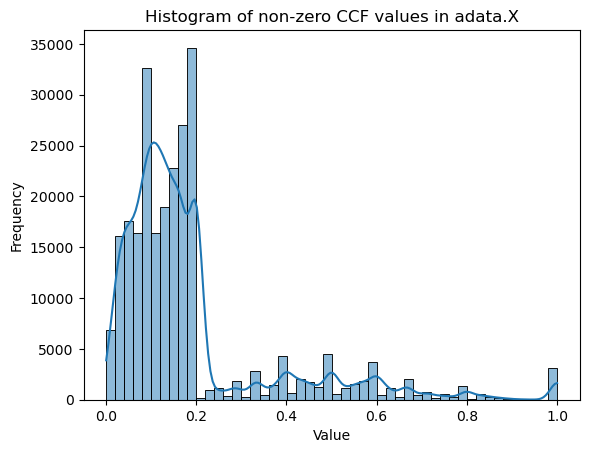

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Extract non-NaN values from adata.X
non_nan_values = adata.X[~np.isnan(adata.X)]
non_nan_non_zero_values = [v for v in non_nan_values if v!=0]

# Plot a histogram of non-NaN values
sns.histplot(non_nan_non_zero_values, bins=50, kde=True)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of non-zero CCF values in adata.X')
plt.show()

In [82]:
stacked_series = pd.DataFrame(adata.layers["mutations_binary_non_zero"]).stack(dropna=False)
stacked_series.value_counts(dropna=False)

NaN    11647662
0.0     1742854
1.0      254072
dtype: int64

In [83]:
stacked_series = pd.DataFrame(adata.layers["mutations_binary_threshold0.01"]).stack(dropna=False)
stacked_series.value_counts(dropna=False)

NaN    11647662
0.0     1744003
1.0      252923
dtype: int64

In [84]:
stacked_series = pd.DataFrame(adata.layers["mutations_binary_threshold0.05"]).stack(dropna=False)
stacked_series.value_counts(dropna=False)

NaN    11647662
0.0     1775339
1.0      221587
dtype: int64

In [85]:
stacked_series = pd.DataFrame(adata.layers["mutations_binary_threshold0.10"]).stack(dropna=False)
stacked_series.value_counts(dropna=False)

NaN    11647662
0.0     1832453
1.0      164473
dtype: int64

In [86]:
stacked_series = pd.DataFrame(adata.layers["mutations_binary_threshold0.15"]).stack(dropna=False)
stacked_series.value_counts(dropna=False)

NaN    11647662
0.0     1890056
1.0      106870
dtype: int64

In [87]:
stacked_series = pd.DataFrame(adata.layers["mutations_binary_threshold0.20"]).stack(dropna=False)
stacked_series.value_counts(dropna=False)

NaN    11647662
0.0     1952200
1.0       44726
dtype: int64

# Prepare mutation matrix

Use the following code to explore the mutation data, find a set of mutations which are callable in a large fraction of the cell types to be used for the tree.
This keep the number of mutations per cell type similar which reduces long branch attraction.

NB these clustermaps are not phylogenetic trees, they are to get an idea of many mutations there are after filtering and broad similarlity between cell types.

This is because clustermaps can't handle NaNs, so NaNs are replaced by -1 for plotting. This makes cell types with more NaN values seem further from the other cell types (when actually those NaN mutations were not callable so shoudln't influence distance).

Once happy with a set of mutations (binarised), these can be saved and tree construction is done in R using 'ape' (in a separate notebook).

NB the distance method used will need to handle the presence of NaNs, many methods, e.g. standard Hamming, do not do this.

## Prepare data

In [66]:
# Remove features in DEGs and DARs
adata=remove_mutations_in_celltype_specific_features(adata, GEX=True, ATAC=True, show_change=True)

Before: (62, 125867)
After: (62, 125867)


In [67]:
adata

View of AnnData object with n_obs × n_vars = 62 × 125867
    obs: 'donor', 'n_cells_GEX', 'n_cells_ATAC', 'fine_grain', 'mid_grain', 'coarse_grain'
    var: 'CHROM', 'Start', 'End', 'REF', 'ALT', 'FILTER', 'Cell_types', 'Up_context', 'Down_context', 'N_ALT', 'Dp', 'Nc', 'Bc', 'Cc', 'VAF', 'CCF', 'BCp', 'CCp', 'Cell_types_min_BC', 'Cell_types_min_CC', 'Rest_BC', 'Rest_CC', 'Fisher_p', 'Cell_type_Filter', 'INFO', 'CCF_mean', 'ALT_unique', 'VAR_ID', 'Gnomad', 'n_cell_types_with_mutation', 'n_cell_types_callable', 'gene_name', 'biotype', 'celltype_specific_gene', 'celltype_specific_peak'
    layers: 'NC_layer', 'mutations_binary_non_zero', 'mutations_binary_threshold0.01', 'mutations_binary_threshold0.05', 'mutations_binary_threshold0.10', 'mutations_binary_threshold0.15', 'mutations_binary_threshold0.20', 'mutations_binary_threshold0.50', 'mutations_binary_threshold0.99'

## Prepare for plotting

In [40]:
# cmap
# grey is NaN (-1), blue is callable and absent (0), red is callable and present (>0)
light_grey = (0.9, 0.9, 0.9)  # RGB values for a lighter grey color
colors_light_grey = [light_grey, "blue", "red"]
cmap = LinearSegmentedColormap.from_list("custom_colormap", colors_light_grey)

In [41]:
# define the fraction of cell types included in tree where the mutation is callable
cell_type_coverage_fraction=0.8

In [42]:
# define which cell types to use for the tree
mask = (adata.obs['coarse_grain'] == 'Cardiomyocytes') & (~adata.obs['fine_grain'].str.contains('Cycling'))

## Heatmap using CCF values (continuous)

keep mutations callable in X% of cell_types...
(125867, 10)
(1159, 10)
drop rows where mutation is callable but absent in all cell_types, not useful information for tree...
(1159, 10)
(211, 10)
fill NaNs to allow clustermap plotting...


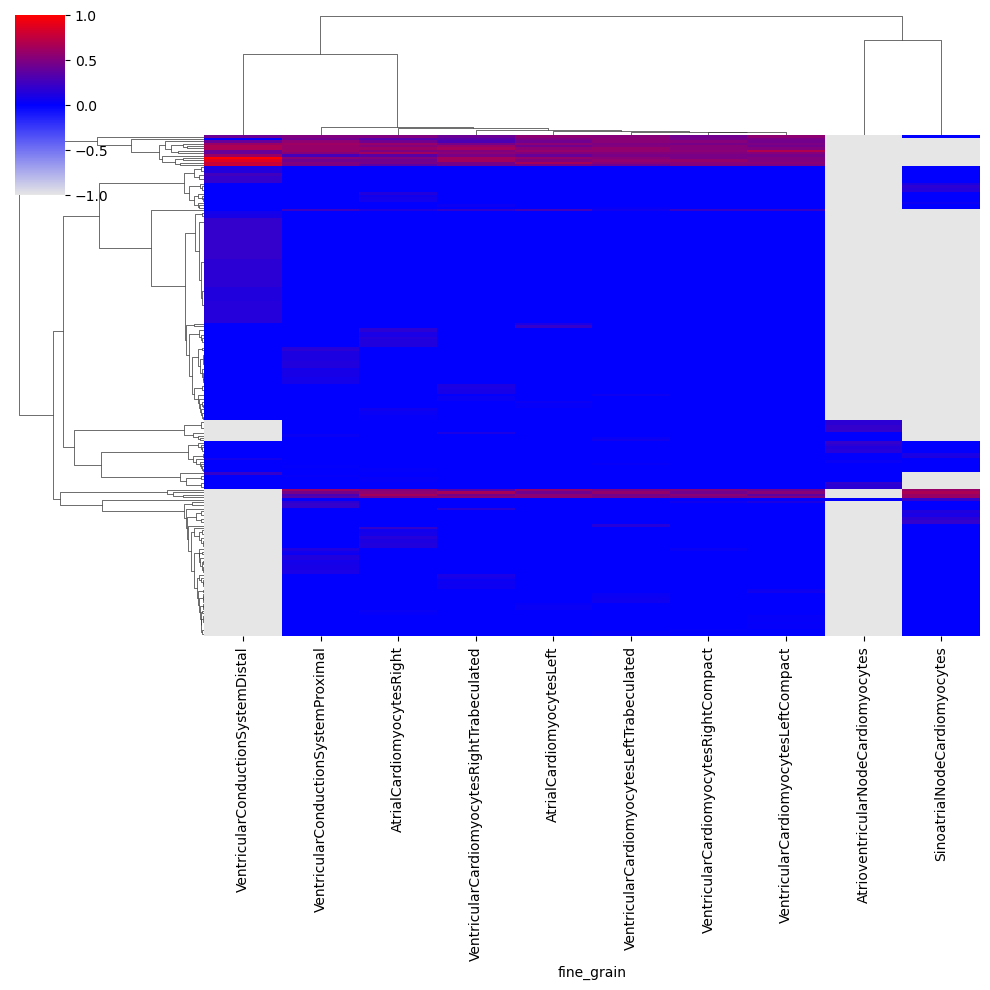

In [43]:
# Subset the AnnData object using the mask
tmp_adata = adata[mask]
data = pd.DataFrame(tmp_adata.X, index=tmp_adata.obs.fine_grain, columns=tmp_adata.var.index).T

print('keep mutations callable in X% of cell_types...')
print(data.shape)
threshold = cell_type_coverage_fraction * len(data.columns)  # At least X% of the row values must be non-NaN
data = data.dropna(thresh=threshold)
print(data.shape)

print('drop rows where mutation is callable but absent in all cell_types, not useful information for tree...')
print(data.shape)
data = data.loc[data.sum(axis=1) != 0]
print(data.shape)

print('fill NaNs to allow clustermap plotting...')
constant=-1
filled_data = data.fillna(constant)

sns.clustermap(filled_data, yticklabels=False, cbar=True, cmap=cmap)

## Heatmap using binarised CCF values

keep mutations callable in X% of cell_types...
(125867, 10)
(1159, 10)
drop rows where mutation is callable but absent in all cell_types, not useful information for tree...
(1159, 10)
(124, 10)
fill NaNs to allow clustermap plotting...


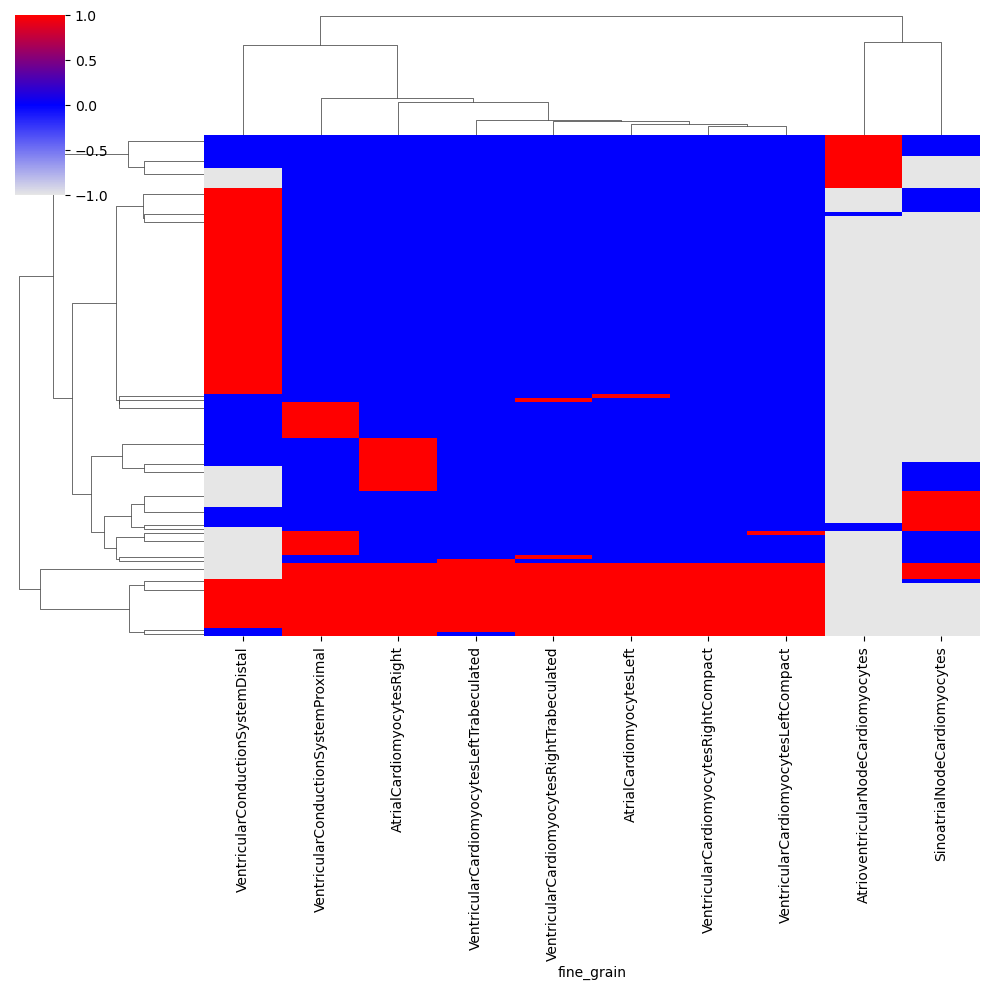

In [44]:
# Subset the AnnData object using the mask
tmp_adata = adata[mask]
data = pd.DataFrame(tmp_adata.layers['mutations_binary_threshold0.10'], index=tmp_adata.obs.fine_grain, columns=tmp_adata.var.index).T

print('keep mutations callable in X% of cell_types...')
print(data.shape)
threshold = cell_type_coverage_fraction * len(data.columns)  # At least X% of the row values must be non-NaN
data = data.dropna(thresh=threshold)
print(data.shape)

print('drop rows where mutation is callable but absent in all cell_types, not useful information for tree...')
print(data.shape)
data = data.loc[data.sum(axis=1) != 0]
print(data.shape)

# keep for mutation matrix (before replacing NaNs)
data_with_NaNs=data

print('fill NaNs to allow clustermap plotting...')
constant=-1
filled_data = data.fillna(constant)

sns.clustermap(filled_data, yticklabels=False, cbar=True, cmap=cmap)

## Save mutation matrix (for tree plotting in R)

In [ ]:
# data_with_NaNs.to_csv('mutation_matrix.csv')

## Heatmap using binarised CCF values, aggregated

When aggregating:

- if aggregated values contain >50% NaNs then value will be NaN
- else if aggregated values contain any 1s then value will be 1
- else value will be 0

In [45]:
def custom_agg(x):
    if x.isna().sum() > len(x) / 2:
        return np.nan
    elif x.any():
        return 1
    else:
        return 0

Make a dictionary to use for aggregation

In [46]:
# Reverse fine_to_mid_dict
mid_to_fine_dict = {}
for fine, mid in fine_to_mid_dict.items():
    if mid in mid_to_fine_dict:
        mid_to_fine_dict[mid].append(fine)
    else:
        mid_to_fine_dict[mid] = [fine]

# view this dictionary (to help make the custom aggregation dictioanry)
mid_to_fine_dict

{'BloodVesselEndothelialCells': ['CoronaryCapillaryEndothelialCells',
  'GreatVesselVenousEndothelialCells',
  'CoronaryVenousEndothelialCells',
  'GreatVesselArterialEndothelialCells',
  'CoronaryArterialEndothelialCells'],
 'LymphoidCells': ['InnateLymphoidCells',
  'BCells',
  'TCellsCD4pos',
  'ProBCells',
  'BCellsMS4A1pos',
  'TregsCD4pos',
  'NaturalKillerCells',
  'TCellsCD8pos'],
 'MyeloidCells': ['Megakaryocytes',
  'MastCells',
  'MacrophagesLYVE1pos',
  'Monocytes',
  'DendriticCellsType1',
  'MacrophagesTIMD4pos',
  'PlasmacytoidDendriticCells',
  'MacrophagesATF3pos',
  'MacrophagesCX3CR1pos',
  'MonocyteDerivedCells',
  'MonocytesMPOpos',
  'DendriticCellsMature'],
 'VentricularCardiomyocytes': ['VentricularCardiomyocytesRightCompact',
  'VentricularCardiomyocytesCycling',
  'VentricularCardiomyocytesLeftCompact',
  'VentricularCardiomyocytesLeftTrabeculated',
  'VentricularCardiomyocytesRightTrabeculated'],
 'Fibroblasts': ['CoronaryVesselAdventitialFibroblasts',
  'Gre

In [47]:
# Define a dictionary to aggregate
# Based on the mid_grain dictionary, but with CCS_nodal and CCS_VCS split
aggregation_dict={
    'BloodVesselEndothelialCells': ['CoronaryCapillaryEndothelialCells',
  'GreatVesselVenousEndothelialCells',
  'CoronaryVenousEndothelialCells',
  'GreatVesselArterialEndothelialCells',
  'CoronaryArterialEndothelialCells'],
 'LymphoidCells': ['InnateLymphoidCells',
  'BCells',
  'TCellsCD4pos',
  'ProBCells',
  'BCellsMS4A1pos',
  'TregsCD4pos',
  'NaturalKillerCells',
  'TCellsCD8pos'],
 'MyeloidCells': ['Megakaryocytes',
  'MastCells',
  'MacrophagesLYVE1pos',
  'Monocytes',
  'DendriticCelfcycllsType1',
  'MacrophagesTIMD4pos',
  'PlasmacytoidDendriticCells',
  'MacrophagesATF3pos',
  'MacrophagesCX3CR1pos',
  'MonocyteDerivedCells',
  'MonocytesMPOpos',
  'DendriticCellsMature'],
 'VentricularCardiomyocytes': ['VentricularCardiomyocytesRightCompact',
  'VentricularCardiomyocytesCycling',
  'VentricularCardiomyocytesLeftCompact',
  'VentricularCardiomyocytesLeftTrabeculated',
  'VentricularCardiomyocytesRightTrabeculated'],
 'Fibroblasts': ['CoronaryVesselAdventitialFibroblasts',
  'GreatVesselAdventitialFibroblasts',
  'MyocardialInterstitialFibroblasts2',
  'MyocardialInterstitialFibroblasts1',
  'Myofibroblasts',
  'ValveInterstitialCells',
  'LymphNodeFibroblasticReticularCells'],
 'AtrialCardiomyocytes': ['AtrialCardiomyocytesLeft',
  'AtrialCardiomyocytesRight',
  'AtrialCardiomyocytesCycling'],
 'PericardialCells': ['PericardialCells1',
  'PericardialCells2',
  'PericardialCells3'],
 'CCS_nodal':['AtrioventricularNodeCardiomyocytes','SinoatrialNodeCardiomyocytes'],
    'CCS_VCS':['VentricularConductionSystemProximal','VentricularConductionSystemDistal'],
 'MuralCells': ['CoronaryPericytes',
  'CoronarySmoothMuscleCells',
  'GreatVesselSmoothMuscleCells',
  'DuctusArteriosusSmoothMuscleCells'],
 'LymphaticEndothelialCells': ['LymphaticEndothelialCells'],
 'EpicardialCells': ['EpicardiumDerivedCells', 'MesothelialEpicardialCells'],
 'EndocardialCells': ['EndocardialCells',
  'ValveEndothelialCells',
  'EndocardialCushionCells'],
 'Neurons': ['ChromaffinCells',
  'SympatheticNeurons',
  'NeuronPrecursors',
  'ParaympatheticNeurons'],
 'Glia': ['SchwannCells', 'SchwannCellPrecursors']}

Perform the aggregation

In [48]:
%%time
tmp_adata = adata
data = pd.DataFrame(tmp_adata.layers['mutations_binary_threshold0.10'], index=tmp_adata.obs.fine_grain, columns=tmp_adata.var.index).T

# Remove any columns from "data" which contain the string "Cycling"
data = data.loc[:, ~data.columns.str.contains('Cycling')]

# Initialize an empty DataFrame for data_aggregated
data_aggregated = pd.DataFrame()

# Filter out dict values that don't exist in the data DataFrame
aggregation_dict = {key: [col for col in value if col in data.columns]
                    for key, value in aggregation_dict.items()}

# Apply the custom aggregation function to the specified columns
for new_col, columns in aggregation_dict.items():
    data_aggregated[new_col] = data[columns].apply(custom_agg, axis=1)

data=data_aggregated
data

CPU times: user 4min 3s, sys: 354 ms, total: 4min 3s
Wall time: 4min 3s


,BloodVesselEndothelialCells,LymphoidCells,MyeloidCells,VentricularCardiomyocytes,Fibroblasts,AtrialCardiomyocytes,PericardialCells,CCS_nodal,CCS_VCS,MuralCells,LymphaticEndothelialCells,EpicardialCells,EndocardialCells,Neurons,Glia
GEX-0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
GEX-1,1.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0
GEX-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GEX-3,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
GEX-4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ATAC-219223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATAC-219224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATAC-219225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ATAC-219226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
cell_type_coverage_fraction=0.9

In [50]:
data_save=data

In [64]:
data=data_save  # recover data from here (while developing)

keep mutations callable in X% of cell_types...
(125867, 15)
(285, 15)
drop rows where mutation is callable but absent in all cell_types, not useful information for tree...
(285, 15)
(120, 15)
fill NaNs to allow clustermap plotting...


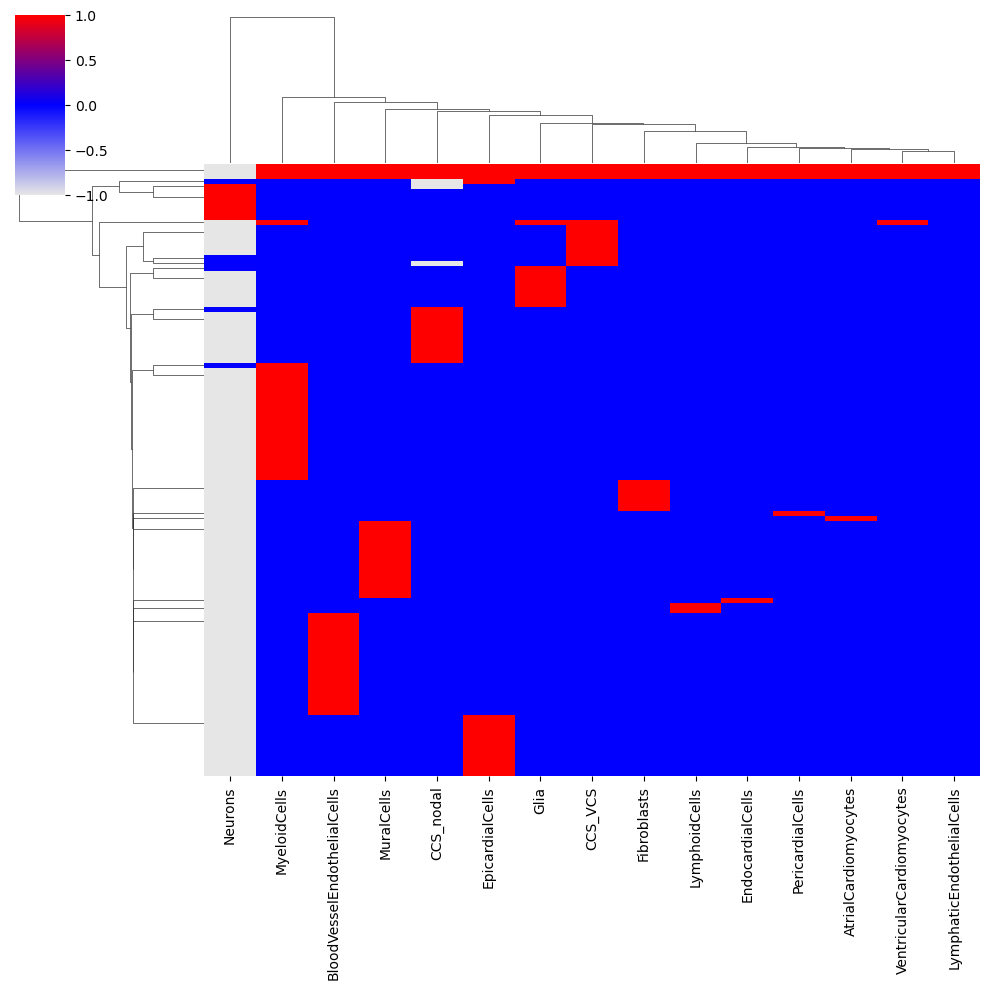

In [65]:
# filter mutations and plot heatmap
print('keep mutations callable in X% of cell_types...')
print(data.shape)
threshold = cell_type_coverage_fraction * len(data.columns)  # At least X% of the row values must be non-NaN
data = data.dropna(thresh=threshold)
print(data.shape)

print('drop rows where mutation is callable but absent in all cell_types, not useful information for tree...')
print(data.shape)
data = data.loc[data.sum(axis=1) != 0]
print(data.shape)

# keep for mutation matrix (before replacing NaNs)
aggregated_data_with_NaNs=data

print('fill NaNs to allow clustermap plotting...')
constant=-1
filled_data = data.fillna(constant)

sns.clustermap(filled_data, yticklabels=False, cbar=True, cmap=cmap)

## Save mutation matrix (for tree plotting in R)

In [68]:
# aggregated_data_with_NaNs.to_csv('aggregated_mutation_matrix.csv')